# Расчет U и V компонет ветра на высоте 10 м и их сравнение с данными реанализа

Расчеты в данном ноутбуке опираются на [данную](https://confluence.ecmwf.int/pages/viewpage.action?pageId=133262398) статью.

## Источники данных

* Данные, полученные с [буёв](https://www.ndbc.noaa.gov/);
* Архив исторических данных о метеопараметрах [rp5](https://rp5.ru);
* Карта с материалами по действующим [метеостанциям, гидропостам и т.д.](http://esimo.ru/dataview/viewresource?resourceId=RU_RIHMI-WDC_2667) (ЕСИМО);
* [Архив](http://meteo.ru/data) данных РОСГИДРОМЕТа. В данном случае использовался [этот раздел](http://meteo.ru/data/163-basic-parameters).
* Информация по координатам метеостанций можно посмотреть [тут](http://meteo.ru/component/content/article/109-katalogi-meteostantsij/684-katalog-meteorologicheskikh-stantsij-620)

Некоторые метеостанции:
* Остров Беринга - 55°12' с.ш., 165°59' в.д. - 55.2 и 165.98
* Петропавловск-Камчатский - 52°59' с.ш. 158°39' в.д. - или 52.98 и 158.65

Координаты углов (южного западного, северрного восточного) для сетки реанализа:
* Минимальные значения по широте 50.79100036621094, и долготе 151.47000122070312
* Максимальные значения по широте 55.79100036621094, и долготе 167.7209930419922


In [3]:
import os
import numpy as np
import pandas as pd

from netCDF4 import Dataset
import datetime
import calendar
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

import seaborn as sns
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib import cm
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

## Загрузка файла для острова Беринга

In [4]:
data_bering = pd.read_csv('D:/Bechev/bering.txt', sep=";", 
                       names=['Station_id','Year','Month','Day', 'Time','Direction','Velocity'])


def prepare_datetime_column(dataframe, new_col, year_col, month_col, day_col= None, time_col = None):
    """
    Функция для формирования столбца с временем из отдельных столцов из даты/времени и т.д.

    :param dataframe: датафрейм для процессинга
    :param new_col: название новой колонки с datetime данными
    :param year_col: название столбца с данными о годах
    :param month_col: название столбца с данными о месяцах
    :param day_col: название столбца с данными о днях
    :param time_col: название столбца с данными о времени (в часах)
    :return: датафрейм с новым столбцом new_col
    """
    datetime_col = []
    for row_id in range(0, len(dataframe)):
        row = dataframe.iloc[row_id]
        if day_col == None:
            string_datetime = ''.join((str(row[year_col]), '.', str(row[month_col])))
        elif time_col == None:
            string_datetime = ''.join((str(row[year_col]), '.', str(row[month_col]), '.', str(row[day_col])))
        else:
            string_datetime = ''.join((str(row[year_col]), '.', str(row[month_col]), '.', str(row[day_col]), '.', str(row[time_col])))
        datetime_col.append(string_datetime)
                                                   
    dataframe[new_col] = datetime_col                                                 
    return(dataframe)

# Загружаем данные для метеостанции для острова Беринга
data_bering = prepare_datetime_column(data_bering,'Date', 'Year', 'Month', 'Day','Time')
data_bering['Date'] = pd.to_datetime(data_bering['Date'], format = '%Y.%m.%d.%H')
data_bering = data_bering.sort_values(by=['Date'])
data_bering.head(2)

,Station_id,Year,Month,Day,Time,Direction,Velocity,Date
0,32618,2009,1,1,0,65,8,2009-01-01 00:00:00
1,32618,2009,1,1,3,70,8,2009-01-01 03:00:00


## Загрузка файла для станции Петропавловск-Камчатский

In [5]:
data_kamchatka = pd.read_csv('D:/Bechev/kamchatka_meteo.txt', sep=";", 
                       names=['Station_id','Year Greenwich','Month Greenwich','Day Greenwich',
                              'Time Greenwich','Month local','Day local','Time local','Hours local','Direction','Velocity'])

# Подготавливаем столбец с datetime
data_kamchatka = prepare_datetime_column(data_kamchatka,'Date', 'Year Greenwich',
                                         'Month Greenwich', 'Day Greenwich','Time Greenwich')
data_kamchatka['Date'] = pd.to_datetime(data_kamchatka['Date'], format = '%Y.%m.%d.%H')
data_kamchatka = data_kamchatka.sort_values(by=['Date'])
data_kamchatka.head(2)

,Station_id,Year Greenwich,Month Greenwich,Day Greenwich,Time Greenwich,Month local,Day local,Time local,Hours local,Direction,Velocity,Date
0,32583,2009,1,1,0,1,1,0,12,50,7,2009-01-01 00:00:00
1,32583,2009,1,1,3,1,1,3,15,55,5,2009-01-01 03:00:00


## Загрузка и подготовка датафрейма для данных с rp5

In [6]:
data_rp5 = pd.read_excel('D:/Bechev/kamchatka_meteo.xls', comment = '#')
data_rp5 = data_rp5[['Местное время в Светлом', 'DD', 'Ff']]
data_rp5 = data_rp5.rename(columns={'Местное время в Светлом': 'Date',
                                    'DD': 'Direction',
                                    'Ff': 'Velocity'})
data_rp5['Date'] = pd.to_datetime(data_rp5['Date'], format = '%d.%m.%Y %H:%M')

# Удаление пустых строк
data_rp5.dropna(inplace=True)

# Функция для перевода текстового описания направления ветра в градусы
def parse_direction(column):
    
    new_values = []
    for element in column:
        # Если начинается со слова штиль, то получаем его
        if element[:5] == 'Штиль':
            code = 0
        else:
            splitted = element.split(' ')
            wind_direction = splitted[-1]
            
            if wind_direction == 'востоко-юго-востока':
                code = 112.5
            elif wind_direction == 'северо-северо-запада':
                code = 337.5
            elif wind_direction == 'севера':
                code = 0
            elif wind_direction == 'северо-запада':
                code = 315
            elif wind_direction == 'запада':
                code = 270
            elif wind_direction == 'северо-северо-востока':
                code = 22.5
            elif wind_direction == 'востоко-северо-востока':
                code = 67.5
            elif wind_direction == 'востока':
                code = 90
            elif wind_direction == 'западо-юго-запада':
                code = 247.5
            elif wind_direction == 'северо-востока':
                code = 45
            elif wind_direction == 'юго-востока':
                code = 135
            elif wind_direction == 'юго-юго-запада':
                code = 202.5
            elif wind_direction == 'юга':
                code = 180
            elif wind_direction == 'юго-юго-востока':
                code = 157.5
            elif wind_direction == 'юго-запада':
                code = 225
        
        new_values.append(code)
    return(new_values)    
            
codes = parse_direction(column=list(data_rp5['Direction']))
data_rp5['Direction'] = codes

## Расчет компонент U и V для острова Беринга

In [7]:
def calculate_uv(dataframe, vel_col, direction_col):
    vel_arr = np.array(dataframe[vel_col])
    direction_arr = np.array(dataframe[direction_col])
    
    # Направление должно быть в радианах
    direction_arr = np.radians(direction_arr) 
    
    # Расчет sin и cos для направлений ветра
    direction_sin = np.sin(direction_arr)
    direction_cos = np.cos(direction_arr)
    
    u_arr = (-1 * vel_arr) * direction_sin
    v_arr = (-1 * vel_arr) * direction_cos
    dataframe['U'] =  u_arr
    dataframe['V'] =  v_arr
    return(dataframe)

result_bering = calculate_uv(data_bering, 'Velocity', 'Direction')
result_bering.drop(columns=['Station_id', 'Year', 'Month', 'Day', 'Time'], inplace = True)
result_bering.head(1)

,Direction,Velocity,Date,U,V
0,65,8,2009-01-01,-7.250462,-3.380946


## Расчет компонент U и V для станции Петропавловск-Камчатский

In [8]:
result_kamchatka = calculate_uv(data_kamchatka, 'Velocity', 'Direction')
result_kamchatka.drop(columns=['Station_id', 'Year Greenwich', 'Month Greenwich', 'Time Greenwich',
                               'Month local', 'Day local', 'Time local', 'Hours local', 'Day Greenwich'], inplace = True)
result_kamchatka.head(1)

,Direction,Velocity,Date,U,V
0,50,7,2009-01-01,-5.362311,-4.499513


## Расчет компонент U и V для данных rp5

In [9]:
result_rp5 = calculate_uv(data_rp5, 'Velocity', 'Direction')
result_rp5.head(1)

,Date,Direction,Velocity,U,V
0,2019-01-01 21:00:00,112.5,9.0,-8.314916,3.444151


## Формирование временных рядов, полученных с реанализа ERA5

Некоторые метеостанции:
* Остров Беринга - 55°12' с.ш., 165°59' в.д. - 55.2 и 165.98
* Петропавловск-Камчатский - 52°59' с.ш. 158°39' в.д. - или 52.98 и 158.65

In [13]:
def add_months(sourcedate, months):
    month = sourcedate.month - 1 + months
    year = sourcedate.year + month // 12
    month = month % 12 + 1
    day = min(sourcedate.day, calendar.monthrange(year,month)[1])
    return datetime.date(year, month, day)

def prepare_data(path, coords, where_to_save, change_timestap = True, vis = False):
    
    # Создаем папку, в которую будем сохранять файлы
    if os.path.isdir(where_to_save) == False:
        os.makedirs(where_to_save)
            
    files = os.listdir(path)
    files.sort()
    
    for index, file in enumerate(files):         
        print(f'Processing... {file}')
        file_path = os.path.join(path, file)
        netcdf_file = Dataset(file_path)
        
        splitted_file = file.split('_')
        splitted_file = splitted_file[-1].split('.')
        start_timestep = splitted_file[0]       
        # Название файла
        filename_csv = ''.join((start_timestep, '.csv'))
        start_timestep = datetime.datetime.strptime(start_timestep, "%Y-%m-%d")
        end_timestep = add_months(start_timestep, 1)
        
        longitude = netcdf_file.variables['longitude']
        latitude = netcdf_file.variables['latitude']
        # Время - количество часов, прошедшее с начала отметки в файле
        time = netcdf_file.variables['time']
        u10 = netcdf_file.variables['u10']
        v10 = netcdf_file.variables['v10']
        
        # Определяем индексы нужного пикселя
        if index == 0:
            # Определить индексы пикселя будет достаточно только
            # один раз
            latitude = np.array(latitude)
            longitude = np.array(longitude)
            
            # Выбираем координату
            lat_coord = coords.get('lat')
            lon_coord = coords.get('lon')
            
            # Рассчитываем расстояния до интересующей нас точки
            lat_dist = latitude - lat_coord
            lon_dist = longitude - lon_coord
            lat_dist = np.abs(lat_dist)
            lon_dist = np.abs(lon_dist)
            
            # Минимальные различия
            lat_index = np.argmin(lat_dist)
            lon_index = np.argmin(lon_dist)
        
        u_arr = np.array(u10)
        v_arr = np.array(v10)            

        if vis == True:
            u_arr_vis = u_arr[0, :,:]
            v_arr_vis = v_arr[0, :,:]
                
            print(f'Минимальные значения по широте {np.min(latitude)}, и долготе {np.min(longitude)}')
            print(f'Максимальные значения по широте {np.max(latitude)}, и долготе {np.max(longitude)}')

            # Индексы найденной точки
            print(f'Координаты искомой точки на заданной сетке: {latitude[lat_index], longitude[lon_index]}')
            print(f'Индексы искомого пикселя: {lat_index, lon_index}')
            
            cmap = cm.get_cmap('jet')
            plt.imshow(u_arr_vis, cmap=cmap)
            plt.colorbar()
            plt.title('U')
            plt.show()
                    
            plt.imshow(v_arr_vis, cmap=cmap)
            plt.colorbar()
            plt.title('V')
            plt.show()
            
        us = u_arr[:, lat_index, lon_index]
        vs = v_arr[:, lat_index, lon_index]
        
        date_range = pd.date_range(start=start_timestep, end=end_timestep, freq='H')
        date_range = date_range[:-1]
        
        if change_timestap == True:
            # Меняем временной шаг на суточную дискретность
            u_series = pd.Series(us, index=date_range)
            v_series = pd.Series(vs, index=date_range)

            u_series = u_series.resample('D').mean()
            v_series = v_series.resample('D').mean()

            # Формируем датафрейм
            dataframe = pd.DataFrame({'U':u_series,
                                      'V':v_series,
                                      'Date':u_series.index})

            save_path = os.path.join(where_to_save, filename_csv)
            dataframe.to_csv(save_path, index = False)
        else:
            # Сохраняем исходную часовую дискретность
            # Формируем датафрейм
            dataframe = pd.DataFrame({'U':us,
                                      'V':vs,
                                      'Date':date_range})

            save_path = os.path.join(where_to_save, filename_csv)
            dataframe.to_csv(save_path, index = False)

In [11]:
# Подготавливаем временной ряд для метеостанции в Петропавловск-Камчастком
prepare_data(path = 'D:/Bechev/era', coords={'lat':52.98,'lon':158.65}, where_to_save = 'D:/Bechev/era_kamchatka', 
             change_timestap = False, vis = False)

Processing... wind_bechevinski_2009-01-01.nc
Processing... wind_bechevinski_2009-02-01.nc
Processing... wind_bechevinski_2009-03-01.nc
Processing... wind_bechevinski_2009-04-01.nc
Processing... wind_bechevinski_2009-05-01.nc
Processing... wind_bechevinski_2009-06-01.nc
Processing... wind_bechevinski_2009-07-01.nc
Processing... wind_bechevinski_2009-08-01.nc
Processing... wind_bechevinski_2009-09-01.nc
Processing... wind_bechevinski_2009-10-01.nc
Processing... wind_bechevinski_2009-11-01.nc
Processing... wind_bechevinski_2009-12-01.nc
Processing... wind_bechevinski_2010-01-01.nc
Processing... wind_bechevinski_2010-02-01.nc
Processing... wind_bechevinski_2010-03-01.nc
Processing... wind_bechevinski_2010-04-01.nc
Processing... wind_bechevinski_2010-05-01.nc
Processing... wind_bechevinski_2010-06-01.nc
Processing... wind_bechevinski_2010-07-01.nc
Processing... wind_bechevinski_2010-08-01.nc
Processing... wind_bechevinski_2010-09-01.nc
Processing... wind_bechevinski_2010-10-01.nc
Processing

In [15]:
prepare_data(path = 'D:/Bechev/era', coords={'lat':55.2,'lon':165.98}, where_to_save = 'D:/Bechev/era_bering', 
             change_timestap = False, vis = False)

Processing... wind_bechevinski_2009-01-01.nc
Processing... wind_bechevinski_2009-02-01.nc
Processing... wind_bechevinski_2009-03-01.nc
Processing... wind_bechevinski_2009-04-01.nc
Processing... wind_bechevinski_2009-05-01.nc
Processing... wind_bechevinski_2009-06-01.nc
Processing... wind_bechevinski_2009-07-01.nc
Processing... wind_bechevinski_2009-08-01.nc
Processing... wind_bechevinski_2009-09-01.nc
Processing... wind_bechevinski_2009-10-01.nc
Processing... wind_bechevinski_2009-11-01.nc
Processing... wind_bechevinski_2009-12-01.nc
Processing... wind_bechevinski_2010-01-01.nc
Processing... wind_bechevinski_2010-02-01.nc
Processing... wind_bechevinski_2010-03-01.nc
Processing... wind_bechevinski_2010-04-01.nc
Processing... wind_bechevinski_2010-05-01.nc
Processing... wind_bechevinski_2010-06-01.nc
Processing... wind_bechevinski_2010-07-01.nc
Processing... wind_bechevinski_2010-08-01.nc
Processing... wind_bechevinski_2010-09-01.nc
Processing... wind_bechevinski_2010-10-01.nc
Processing

### Состалвяем датафрейм с временым рядом для данных ERA5

In [10]:
def make_era_dataframe(csv_path):
    files = os.listdir(csv_path)
    files.sort()

    all_us = []
    all_vs = []
    dates = []
    for file in files:
        file_path = os.path.join(csv_path, file)
        dataset = pd.read_csv(file_path)
        all_us.extend(list(dataset['U']))
        all_vs.extend(list(dataset['V']))
        dates.extend(list(dataset['Date']))

    main_dataset = pd.DataFrame({'U': all_us,
                                 'V': all_vs,
                                 'Date': dates})
    main_dataset['Date'] = pd.to_datetime(main_dataset['Date'], format = '%Y-%m-%d')
    return(main_dataset)

# Составляем датасеты по данным реанализа
era_kamchatka = make_era_dataframe('D:/Bechev/era_kamchatka')
era_bering = make_era_dataframe('D:/Bechev/era_bering')
era_bering.head(5)

,U,V,Date
0,-13.519782,1.169351,2009-01-01 00:00:00
1,-13.270457,0.623360,2009-01-01 01:00:00
2,-13.488325,0.107211,2009-01-01 02:00:00
3,-13.285020,-0.637171,2009-01-01 03:00:00
4,-12.829478,-0.896351,2009-01-01 04:00:00


## Сопоставление фременных рядов с метеостанций и с данных реанализа

Временные ряды с метеостанций:
* result_kamchatka
* result_bering

Временные ряды с реанализа:
* era_kamchatka
* era_bering

Временной ряд с rp5 не используется, так как ряд неполный и местоположение метеостанции практически совпадает с метеостанцией "Петропавловск-Камчатский"

In [11]:
result_kamchatka = result_kamchatka.rename(columns={'U': 'U_meteo',
                                                    'V': 'V_meteo'})

result_bering = result_bering.rename(columns={'U': 'U_meteo',
                                              'V': 'V_meteo'})

In [12]:
bering_df = era_bering.merge(result_bering, on = 'Date')
kamchatka_df = era_kamchatka.merge(result_kamchatka, on = 'Date')

In [16]:
def make_comparison(dataframe):
    plt.plot(dataframe['Date'], dataframe['U_meteo'], label='Данные с метеостанции', alpha=0.8, c = 'blue')
    plt.plot(dataframe['Date'], dataframe['U'], label='Данные реанализа', alpha=0.8, c = 'red')
    plt.ylabel('U компонента, м/с', fontsize=15)
    plt.xlabel('Дата', fontsize=15)
    plt.legend()
    plt.grid()
    plt.show()

    plt.plot(dataframe['Date'], dataframe['V_meteo'], label='Данные с метеостанции', alpha=0.8, c = 'blue')
    plt.plot(dataframe['Date'], dataframe['V'], label='Данные реанализа', alpha=0.8, c = 'red')
    plt.ylabel('V компонента, м/с', fontsize=15)
    plt.xlabel('Дата', fontsize=15)
    plt.legend()
    plt.grid()
    plt.show()
    
    mae_v = mean_absolute_error(dataframe['V_meteo'], dataframe['V'])
    mae_u = mean_absolute_error(dataframe['U_meteo'], dataframe['U'])

    korr_v = stats.pearsonr(dataframe['V_meteo'], dataframe['V'])
    korr_u = stats.pearsonr(dataframe['U_meteo'], dataframe['U'])

    print(f'Среднаяя абсолютная ошибка, м/с для U - {mae_u} и V - {mae_v}')
    print(f'Коэффициент корреляции для U - {korr_u[0]} и V - {korr_v[0]}')

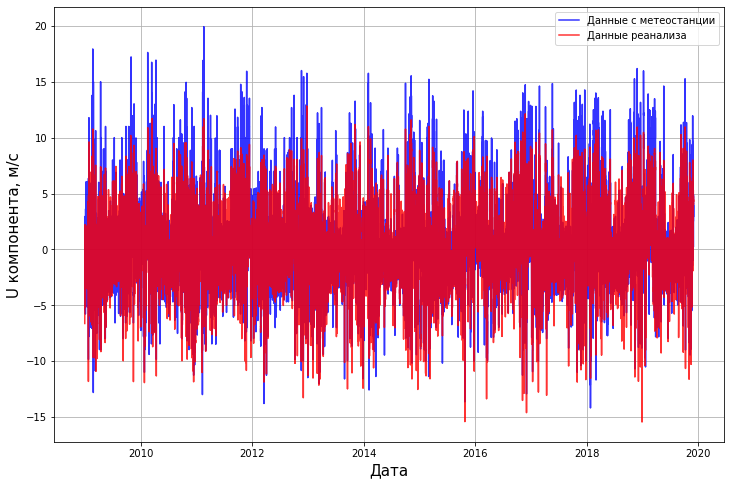

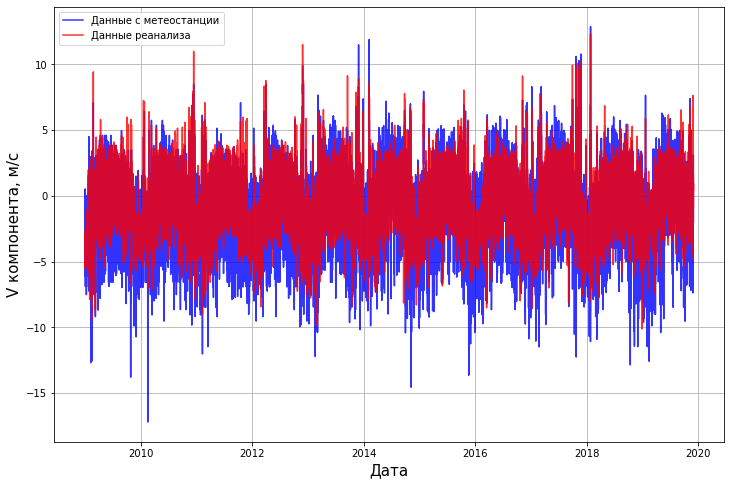

Среднаяя абсолютная ошибка, м/с для U - 1.8428976266238932 и V - 1.6507834100444827
Коэффициент корреляции для U - 0.7836819222185276 и V - 0.7195862471811798


In [17]:
make_comparison(kamchatka_df)

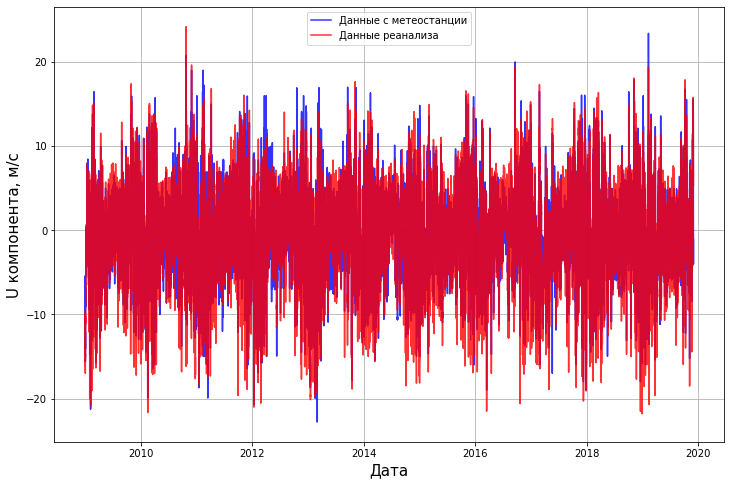

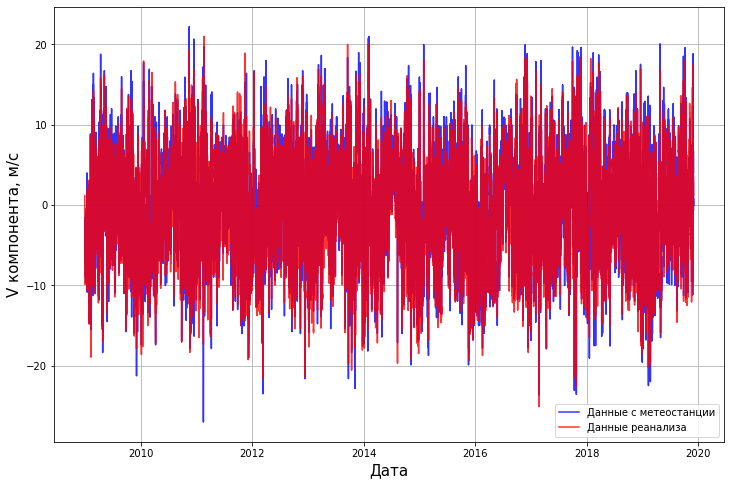

Среднаяя абсолютная ошибка, м/с для U - 2.366856187181046 и V - 1.7910276354429173
Коэффициент корреляции для U - 0.8618412764216863 и V - 0.9351448382340073


In [19]:
make_comparison(bering_df)